## Project 2. Pricing American Options

In [2]:
import numpy as np   # math operations
import numpy.random as npr # random 
import matplotlib.pyplot as plt # plot

from scipy import linalg
from scipy import stats
from scipy.stats import norm

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

On commence à calculer le prix d'une option de vente Bermudienne en utilisant la méthode de Monte-Carlo avec la technique d'exercice anticipé de Longstaff & Schwartz.

Tout d'abord, on initialise les variables nécessaires telles que le pas de temps dt, la matrice de nombres aléatoires Gaussiens G qui représente l'évolution aléatoire de l'actif sous-jacent de l'option au fil du temps, et le vecteur de retour des logarithmes de rendement LR, qui est calculé à partir du taux d'intérêt sans risque r, du prix initial de l'actif sous-jacent S0, de la volatilité sigma, et du temps jusqu'à l'échéance T. Les rendements logarithmiques (LR) sont calculés en utilisant la formule du modèle de Black-Scholes. La matrice LR est ensuite étendue avec le prix initial de l'actif sous-jacent pour obtenir les trajectoires des prix de l'actif sous-jacent (Spaths).

Les trajectoires d'évolution des prix de l'actif sous-jacent Spaths sont calculées à partir de LR à l'aide de l'opération exponentielle.

 On applique la méthode de Longstaff & Schwartz pour estimer le prix de l'option Bermudienne. Elle consiste à partir de la date d'échéance de l'option et à remonter en arrière jusqu'à la date d'achat pour estimer le prix d'exercice anticipé de l'option à chaque étape.

Si le prix d'exercice anticipé est plus élevé que le flux de trésorerie futur, l'option est exercée et les flux de trésorerie futurs sont mis à jour pour prendre en compte la valeur d'exercice.

Enfin, le prix de l'option est calculé à partir des flux de trésorerie futurs actualisés, et un intervalle de confiance à 95 % est également calculé à l'aide de la formule standard pour les intervalles de confiance de Monte-Carlo.

In [76]:
def Bermudean_Put_MC_LS(r,S0,sigma,T,K,N,n, basis_size):
    dt = float(T/n) #calcule le pas de temps entre chaque itération de la simulation Monte Carlo.
    G = npr.normal(0,1,size=(N,n))

    #Log returns
    LR = (r - 0.5 * sigma**2) * dt + np.sqrt(dt) * sigma * G
    # concatenate with log(S0)
    LR = np.concatenate((np.log(S0) * np.ones((N,1)), LR), axis=1)
    # cumsum horizontally (axis=1)
    LR = np.cumsum(LR, axis=1)
    # take the expo Spath matrix pour obtenir les prix simulés de l'actif sous-jacent à chaque pas de temps.
    Spaths = np.exp(LR)
    
    # Longstaff & Schwartz
    #discount rates over different time intervals
    discountVect = np.exp(-r*dt*np.arange(1, n+1, 1)) # calcule les facteurs d'actualisation pour chaque pas de temps de la simulation.
    
    #generate sample paths
    CashFlows = np.maximum(0, K-Spaths[:,- 1]) # all scenarios of the payoff max(K-ST,0) at maturity
    
    # N : MONTE CARLO SCENARIOS
    ExerciseTime = n* np.ones(N)
    ExerciseTime = ExerciseTime.astype('int')
    
    Tau=[] # Continuation value average
    
    for step in range(n-1, -1, -1): #backward for loop
        Time_to_maturity = n * np.ones(N) - step
        
        index_in_money = np.argwhere(Spaths[:, step] < K)
        X = Spaths[index_in_money, step]  # X= S_{t_k} t_k is the step where I am in the for loop
       
        #np.ones((X.shape[0],1))
        Reg_list = []
        for degree in range(basis_size):
            Reg_list.append(X**degree)
       
        RegrMat = np.array(Reg_list) #(1, Stk, Stk^2, Stk^3, Stk^4) basis of size 5
        YData = CashFlows[index_in_money] * discountVect[ExerciseTime[index_in_money] - step - 1]
        
        a = linalg.lstsq(np.squeeze(RegrMat.T),YData)[0] # finding the regressors 
        IntrinsicValue =  K - X;
        ContinuationValue = np.dot(np.squeeze(RegrMat.T), a) #approximation for the conditional expectation
        index_Exercise = np.argwhere(IntrinsicValue > ContinuationValue)
        k = index_in_money[index_Exercise]
        
        CashFlows[k] = IntrinsicValue[index_Exercise];
        ExerciseTime[k] = step
        Tau.append(np.mean(ExerciseTime))
        

    payoff = CashFlows * discountVect[ExerciseTime - 1]
    Bermudean_MC_price = np.mean(payoff)

    # 95% C.I
    STD = np.std(payoff) # standard deviation estimator
    error = 1.96 * STD / np.sqrt(N)
    CI_up = Bermudean_MC_price + error
    CI_down = Bermudean_MC_price - error
    
    # plot the option price evolution over time
    plt.figure()
    plt.plot(Tau[::-1], payoff[-len(Tau):][::-1], color='black', label='Option Price')
    plt.fill_between(Tau[::-1], CI_up, CI_down, alpha=0.2, label='95% Confidence Interval')
    plt.legend()
    plt.title("Évolution du prix de l'option put Bermudéenne en fonction du temps jusqu'à l'échéance")
    plt.xlabel('Time to Maturity (in periods)')
    plt.ylabel('Option Price')
    plt.show()
    
    # plot the simulated asset price paths
    plt.figure()
    plt.plot(np.arange(0, T+dt, dt), Spaths.T, lw=1.5) # spaths[0] permet de voir une seule trajectoire 
    plt.title("Trajectoire des prix simulés de l'actif sous-jacent")
    plt.xlabel('Time')
    plt.ylabel('Asset Price')
    plt.show()

    return {'Bermudean_MC_price': Bermudean_MC_price,
        'CI_up': CI_up,
        'CI_down': CI_down,
        'error': error,
        'Tau': Tau}




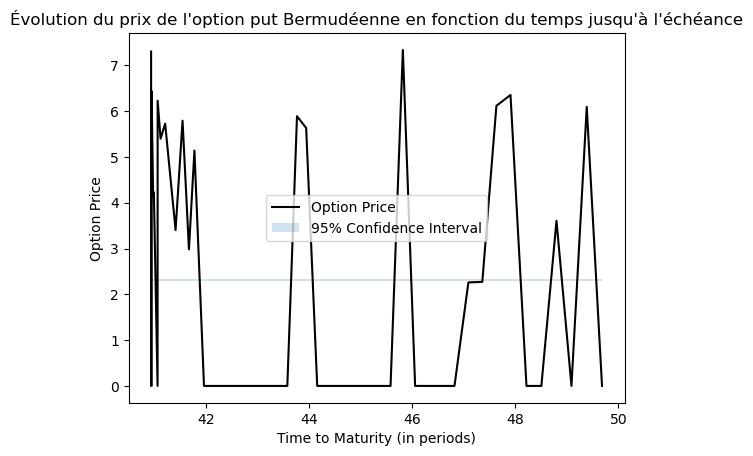

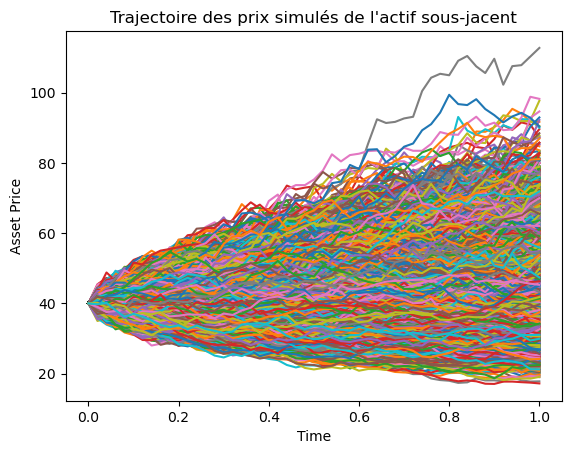

{'Bermudean_MC_price': 2.314320528355871,
 'CI_up': 2.3313139684195785,
 'CI_down': 2.2973270882921635,
 'error': 0.016993440063707455,
 'Tau': [49.68367,
  49.38729,
  49.09048,
  48.79983,
  48.50639,
  48.21741,
  47.90729,
  47.63366,
  47.36003,
  47.08986,
  46.8199,
  46.54753,
  46.30377,
  46.05587,
  45.81771,
  45.57885,
  45.36001,
  45.1047,
  44.85012,
  44.63162,
  44.39147,
  44.15506,
  43.94095,
  43.76293,
  43.57517,
  43.39109,
  43.14066,
  42.91665,
  42.71763,
  42.54812,
  42.33925,
  42.14311,
  41.95779,
  41.7719,
  41.66549,
  41.54137,
  41.40584,
  41.20371,
  41.11512,
  41.05779,
  41.05646,
  40.99435,
  40.98374,
  40.97018,
  40.93993,
  40.93993,
  40.93993,
  40.93105,
  40.93105,
  40.93105]}

In [77]:
Bermudean_Put_MC_LS(0.06,40,0.2,1,40,100000,50,5)

Le graphique des trajectoires montre l'évolution des prix simulés de l'actif sous-jacent pour différents temps d'exercice. Chaque courbe représente l'évolution du prix de l'actif sous-jacent depuis le début jusqu'à l'échéance pour un temps d'exercice spécifique. Lorsque le temps d'exercice change, une nouvelle courbe est tracée pour représenter l'évolution du prix de l'actif sous-jacent pour ce nouveau temps d'exercice.

En appliquant plusieurs simulations, la méthode de Monte Carlo permet de prendre en compte la diversité et la complexité des situations possibles, plutôt que de se baser sur des hypothèses simplistes et souvent incorrectes. Cela permet d'obtenir des estimations plus précises des prix d'options et des risques associés.

En analysant les plots, on peut voir comment les prix de l'actif sous-jacent évoluent pour chaque scénario (qui change d'un temps d'exercice à l'autre, mais pour les memes paramètres sigma, r et K) au fil du temps. On peut également identifier les scénarios extrêmes (par exemple, les scénarios où le prix de l'actif sous-jacent diminue ou augmente) et comment ils affectent le prix de l'option.

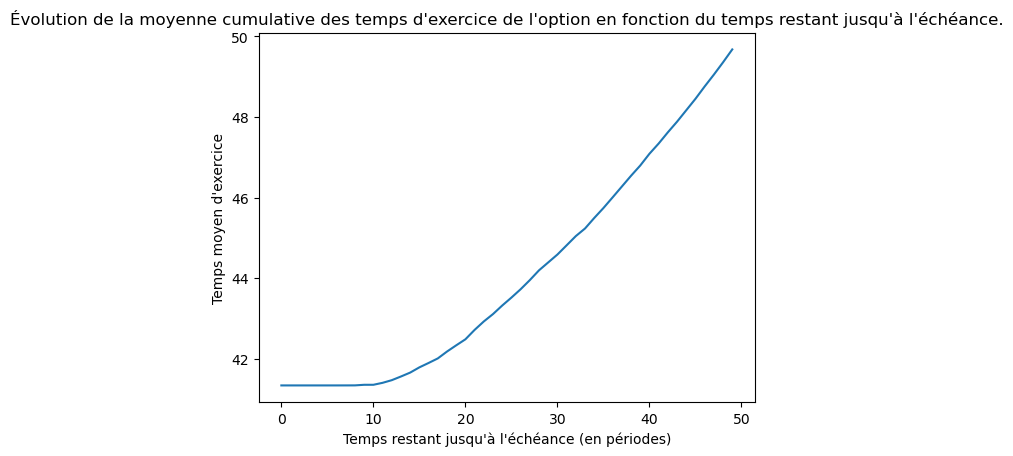

In [53]:
plt.plot(Tau[::-1])
plt.title("Évolution de la moyenne cumulative des temps d'exercice de l'option en fonction du temps restant jusqu'à l'échéance.")
plt.xlabel('Temps restant jusqu\'à l\'échéance (en périodes)')
plt.ylabel('Temps moyen d\'exercice')
plt.show()

Le fait que la courbe soit croissante signifie que le temps moyen d'exercice augmente à mesure que l'on s'approche de l'échéance.

Cela peut sembler contre-intuitif, car on pourrait s'attendre à ce que le temps moyen d'exercice diminue à mesure que l'on se rapproche de l'échéance. Cependant, cela peut être expliqué par le fait que le prix de l'option est plus susceptible d'être exercé lorsque le temps restant jusqu'à l'échéance est plus court et que l'option est plus profondément dans la monnaie.

Par conséquent, à mesure que l'on se rapproche de l'échéance, les scénarios dans lesquels l'option est exercée ont tendance à être ceux où le prix de l'actif sous-jacent est plus proche de la barrière d'exercice. Ces scénarios ont un temps moyen d'exercice plus élevé, ce qui explique pourquoi la courbe est croissante.

## Tasks:

Use a deep neural network to approximate the conditional expectation appearing in the continuation condition  in order to compute the Bermudean put price. Compare its efficiency with the above Longstaff Schwarz algorithm. 

On commence par la construction d'un rèseau de neuronnes simple, sans faire l'implèmentation de Longstaff Schwarz pour voir la performance du modèle lors du calcul du prix.

In [7]:
def Bermudan_NN_simple(S0, K, r, sigma, T, N, M, batch_size):
    # Génération des trajectoires de prix de l'actif sous-jacent
    def generate_paths(S0, K, r, sigma, T, M, N):
        dt = T / M
        S = np.zeros((N, M+1))
        S[:,0] = S0
        for i in range(1, M+1):
            dW = np.random.normal(scale=np.sqrt(dt), size=N)
            S[:,i] = S[:,i-1] * np.exp((r - sigma**2/2)*dt + sigma*dW)
        return S

    # Évaluation de la continuation conditionnelle à chaque étape de temps
    def evaluate_continuation_value(S, K, r, T, t):
        V = np.maximum(K - S, 0.0)
        for i in range(M-1, t-1, -1):
            X = np.column_stack((S[:,i], V[:,i+1]))
            model = create_model()
            model.fit(X, V[:,i+1], epochs=100, verbose=0)
            V[:,i] = model.predict(X)[:,0]
            V[:,i] = np.maximum(K - S[:,i], V[:,i])
        return V[:,t]

    # Définition du modèle de réseau de neurones
    def create_model():
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(32, input_shape=(2,), activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    # Génération des données d'entraînement
    S = generate_paths(S0, K, r, sigma, T, M, batch_size)
    X = np.column_stack((S[:,0], np.zeros(batch_size)))
    y = evaluate_continuation_value(S, K, r, T, 0)

    # Entraînement du modèle de réseau de neurones
    model = create_model()
    history = model.fit(X, y, epochs=10,validation_split=0.2, verbose=0)

    # Calcul du prix de l'option Bermudéenne en utilisant le réseau de neurones
    S = generate_paths(S0, K, r, sigma, T, M, N)
    X = np.column_stack((S[:,0], np.zeros(N)))
    V = np.maximum(K - S[:,-1], 0.0)
    for i in range(M-1, 0, -1):
        X = np.column_stack((S[:,i], V))
        V = model.predict(X)[:,0]
        V = np.maximum(K - S[:,i], V)

    bermudan_put_nn = np.mean(V) * np.exp(-r*T)
    

    # Plot de la loss function
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train','validation'],loc= 'upper left')
    plt.show() 
    print("Prix de l'option Bermudéenne avec un réseau de neurones: ", bermudan_put_nn)

La première étape de la fonction est de générer des trajectoires de prix de l'actif sous-jacent en utilisant la méthode de Monte Carlo. Cette étape est effectuée à l'aide de la fonction generate_paths.

Ensuite, la fonction évalue la continuation conditionnelle à chaque étape de temps en utilisant le modèle de réseau de neurones. Cette étape est effectuée à l'aide de la fonction evaluate_continuation_value. Cette fonction itère sur chaque étape de temps en partant de la dernière étape et en remontant jusqu'à la première étape. Pour chaque étape de temps, la fonction utilise le modèle de réseau de neurones pour évaluer la continuation conditionnelle et détermine le prix de l'option Bermudéenne.

La fonction utilise également la fonction create_model pour définir le modèle de réseau de neurones utilisé pour l'évaluation de la continuation conditionnelle. Cette fonction retourne un modèle compilé.

La fonction entraine ensuite le modèle de réseau de neurones en utilisant les données générées et évaluées précédemment.

La fonction calcule enfin le prix de l'option Bermudéenne en utilisant les trajectoires de prix générées et le modèle de réseau de neurones entrainé

3125/3125 [==============================] - 3s 830us/step


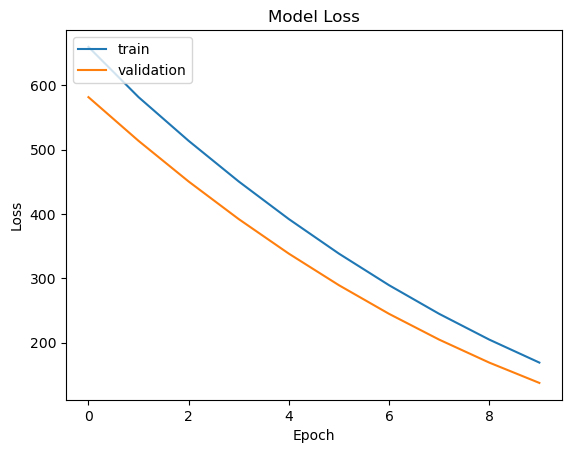

Prix de l'option Bermudéenne avec un réseau de neurones:  13.15550966858334


In [8]:
# Définition des paramètres de l'option
S0 = 100.0  # prix initial de l'actif sous-jacent
K = 40  # prix d'exercice
r = 0.06  # taux d'intérêt sans risque
sigma = 0.21  # volatilité
T = 1.0  # maturité de l'option
M = 40  # nombre de dates d'exercice possibles
N = 100000
batch_size = 10

Bermudan_NN_simple(S0, K, r, sigma, T, N, M, batch_size)

Ensuite on implemente l'algorithme Longstaff Schwarz avec un réseau de neuronnes. On essaye deux implémentations: prémierement pour $N = 10,000$ et evec $10$ epochs et ensuite avec $N = 100,000$ et $20$ epochs. On rajoute un paramètre avec patience pour optimiser le temps d'exécution du code et el rendre mieux performant.

In [12]:
def Bermudean_Put_MC_NN(r, S0, sigma, T, K, N, n, basis_size, hidden_units, epochs):
    dt = float(T / n)
    G = npr.normal(0, 1, size=(N, n))
    
    # Log returns
    LR = (r - 0.5 * sigma**2) * dt + np.sqrt(dt) * sigma * G
    LR = np.concatenate((np.log(S0) * np.ones((N, 1)), LR), axis=1)
    LR = np.cumsum(LR, axis=1)
    Spaths = np.exp(LR)
    
    discountVect = np.exp(-r * dt * np.arange(1, n+1, 1))
    CashFlows = np.maximum(0, K - Spaths[:, -1])
    
    ExerciseTime = n * np.ones(N, dtype=int)
    Tau = []
    loss_history = []

    # Build and train the neural network
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='relu', input_shape=(basis_size,)))
    #model.add(tf.keras.layers.Dense(hidden_units, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    
    # Enable eager execution mode
    tf.config.run_functions_eagerly(True)
    
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='mse')
    
    for step in range(n-1, -1, -1):
        Time_to_maturity = n * np.ones(N) - step
        index_in_money = np.argwhere(Spaths[:, step] < K)
        X = Spaths[index_in_money, step]
        X = X.flatten()
        
        common_indices = np.intersect1d(index_in_money, np.arange(len(X)))
        RegrMat = np.empty((len(common_indices), basis_size))
        
        for degree in range(basis_size):
            RegrMat[:, degree] = X[common_indices]**degree
            
        YData = CashFlows[index_in_money[common_indices]] * discountVect[ExerciseTime[index_in_money[common_indices]] - step - 1]
        
        RegrMat = np.array(RegrMat)
        YData = np.array(YData)
        
        print("RegrMat shape:", RegrMat.shape)
        print("YData shape:", YData.shape)
        
        if RegrMat.shape[0] == 0 or YData.shape[0] == 0:
            print("Skipping empty training step.")
            continue
        
        try:
            callbacks = EarlyStopping(monitor='val_loss', patience=15)
            history = model.fit(RegrMat, YData, epochs=10, callbacks=[callbacks], validation_split=0.2, verbose=0)
        except ValueError as e:
            print("Error during model training:", str(e))
        
        IntrinsicValue = K - X
        ContinuationValue = model.predict(RegrMat).flatten()
        
        min_length = min(len(IntrinsicValue), len(ContinuationValue))
        IntrinsicValue = IntrinsicValue[:min_length]
        ContinuationValue = ContinuationValue[:min_length]
        
        index_Exercise = np.where(IntrinsicValue > ContinuationValue)[0]
        k = index_in_money[index_Exercise]

        
        CashFlows[k] = IntrinsicValue[index_Exercise][:, np.newaxis]
        ExerciseTime[k] = step

        Tau.append(np.mean(ExerciseTime))
    
      
    payoff = CashFlows * discountVect[ExerciseTime - 1]
    Bermudean_MC_price = np.mean(payoff)
    STD = np.std(payoff)
    error = 1.96 * STD / np.sqrt(N)
    CI_up = Bermudean_MC_price + error
    CI_down = Bermudean_MC_price - error
    
    plt.figure()
    if len(Tau) != len(payoff):
        payoff = payoff[-len(Tau):]
    plt.plot(Tau[::-1], payoff[::-1], color='black', label='Option Price')
    plt.fill_between(Tau[::-1], CI_up, CI_down, alpha=0.2, label='95% Confidence Interval')
    plt.legend()
    plt.title("Evolution of Bermudan Put Option Price with Time to Maturity")
    plt.xlabel('Time to Maturity (in periods)')
    plt.ylabel('Option Price')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train','validation'],loc= 'upper left')
    plt.show()          
    


    return {'Bermudean_MC_price': Bermudean_MC_price,
        'CI_up': CI_up,
        'CI_down': CI_down,
        'error': error,
        'Tau': Tau}



RegrMat shape: (1697, 5)
YData shape: (1697, 1)
54/54 [==============================] - 0s 1ms/step
RegrMat shape: (1714, 5)
YData shape: (1714, 1)
54/54 [==============================] - 0s 1ms/step
RegrMat shape: (1746, 5)
YData shape: (1746, 1)
55/55 [==============================] - 0s 1ms/step
RegrMat shape: (1750, 5)
YData shape: (1750, 1)
55/55 [==============================] - 0s 1ms/step
RegrMat shape: (1749, 5)
YData shape: (1749, 1)
55/55 [==============================] - 0s 1ms/step
RegrMat shape: (1769, 5)
YData shape: (1769, 1)
56/56 [==============================] - 0s 1ms/step
RegrMat shape: (1761, 5)
YData shape: (1761, 1)
56/56 [==============================] - 0s 1ms/step
RegrMat shape: (1771, 5)
YData shape: (1771, 1)
56/56 [==============================] - 0s 1ms/step
RegrMat shape: (1775, 5)
YData shape: (1775, 1)
56/56 [==============================] - 0s 1ms/step
RegrMat shape: (1744, 5)
YData shape: (1744, 1)
55/55 [==============================] - 0s

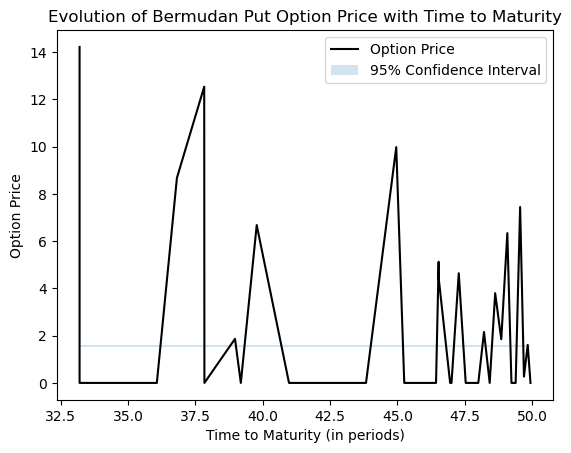

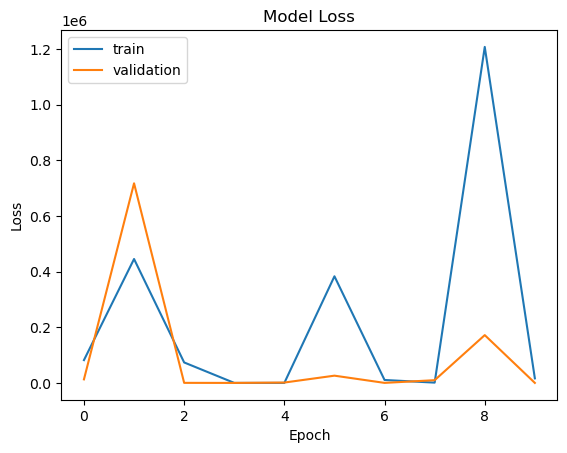

{'Bermudean_MC_price': 1.5710351916232999,
 'CI_up': 1.6219819561203785,
 'CI_down': 1.5200884271262212,
 'error': 0.05094676449707875,
 'Tau': [49.9401,
  49.8369,
  49.6979,
  49.5556,
  49.3895,
  49.2336,
  49.0804,
  48.8554,
  48.6296,
  48.426,
  48.2153,
  48.0029,
  47.8453,
  47.5361,
  47.278,
  47.0086,
  46.9573,
  46.5318,
  46.5318,
  46.4341,
  45.9336,
  45.3291,
  45.2776,
  45.255,
  44.9575,
  43.8348,
  43.8348,
  43.6535,
  42.725,
  42.436,
  41.8822,
  41.4161,
  40.9945,
  40.9945,
  40.9774,
  39.7785,
  39.1883,
  39.1883,
  38.9724,
  37.8367,
  37.8296,
  36.8165,
  36.0715,
  35.3962,
  35.2708,
  34.1904,
  33.2033,
  33.2033,
  33.2033]}

In [13]:
# Example avec N = 10 000, 10 epochs

np.random.seed(1)
r = 0.06  # Risk-free interest rate
S0 = 40  # Initial asset price
sigma = 0.2  # Volatility
T = 1.0  # Time to maturity
K = 40  # Strike price
N = 10000  # Number of Monte Carlo scenarios
n = 50  # Number of time steps
basis_size = 5  # Size of the polynomial basis
hidden_units = 32  # Number of hidden units in the neural network
epochs = 10 # Number of training epochs

Bermudean_Put_MC_NN(r, S0, sigma, T, K, N, n, basis_size, hidden_units, epochs)



RegrMat shape: (17774, 5)
YData shape: (17774, 1)
556/556 [==============================] - 1s 1ms/step
RegrMat shape: (17914, 5)
YData shape: (17914, 1)
560/560 [==============================] - 1s 1ms/step
RegrMat shape: (17989, 5)
YData shape: (17989, 1)
563/563 [==============================] - 1s 1ms/step
RegrMat shape: (18044, 5)
YData shape: (18044, 1)
564/564 [==============================] - 1s 1ms/step
RegrMat shape: (18102, 5)
YData shape: (18102, 1)
566/566 [==============================] - 1s 1ms/step
RegrMat shape: (18177, 5)
YData shape: (18177, 1)
569/569 [==============================] - 1s 1ms/step
RegrMat shape: (18246, 5)
YData shape: (18246, 1)
571/571 [==============================] - 1s 1ms/step
RegrMat shape: (18307, 5)
YData shape: (18307, 1)
573/573 [==============================] - 1s 1ms/step
RegrMat shape: (18326, 5)
YData shape: (18326, 1)
573/573 [==============================] - 1s 1ms/step
RegrMat shape: (18260, 5)
YData shape: (18260, 1)
571/5

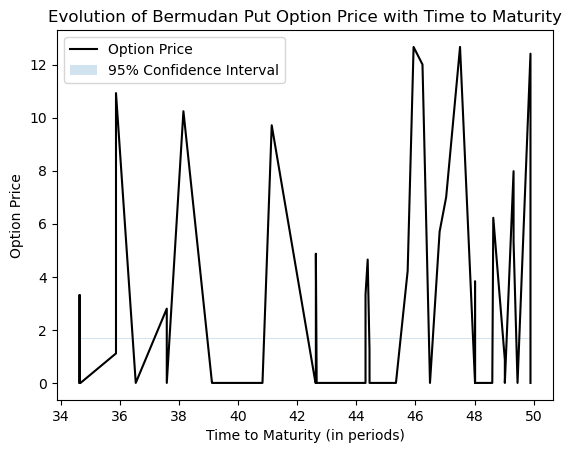

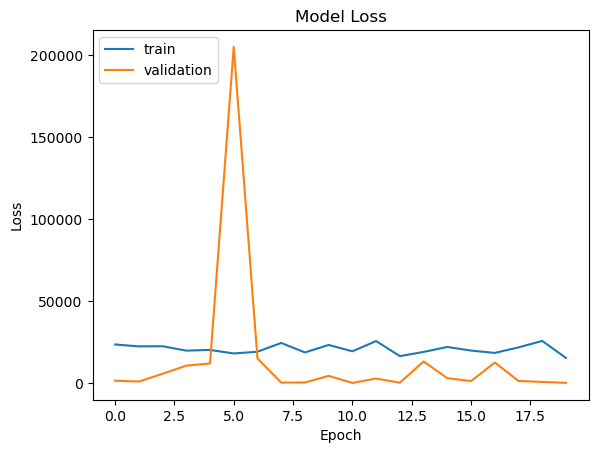

{'Bermudean_MC_price': 1.672031213788123,
 'CI_up': 1.6881915517587467,
 'CI_down': 1.6558708758174994,
 'error': 0.0161603379706236,
 'Tau': [49.89124,
  49.89124,
  49.45328,
  49.31901,
  49.31901,
  49.02387,
  49.02387,
  48.63272,
  48.59903,
  48.01572,
  48.01572,
  48.01502,
  47.50787,
  47.03869,
  46.81723,
  46.49134,
  46.23739,
  45.93625,
  45.73594,
  45.33993,
  45.25493,
  45.14871,
  44.44656,
  44.44501,
  44.38348,
  44.31025,
  44.31025,
  44.31025,
  42.65762,
  42.63025,
  42.63025,
  42.61808,
  41.13663,
  40.82417,
  40.16201,
  39.65426,
  39.12072,
  39.116,
  38.14955,
  37.58647,
  37.58647,
  36.53663,
  35.86821,
  35.86821,
  34.66839,
  34.63613,
  34.63613,
  34.63613,
  34.63613]}

In [15]:
# Exemple avec N = 100 000, 20 epochs.
np.random.seed(1)
r = 0.06  # Risk-free interest rate
S0 = 40  # Initial asset price
sigma = 0.2  # Volatility
T = 1.0  # Time to maturity
K = 40  # Strike price
N = 100000  # Number of Monte Carlo scenarios
n = 50  # Number of time steps
basis_size = 5  # Size of the polynomial basis
hidden_units = 32  # Number of hidden units in the neural network
epochs = 20 # Number of training epochs

Bermudean_Put_MC_NN(r, S0, sigma, T, K, N, n, basis_size, hidden_units, epochs)